In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/zhigan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out_Zhiganov_Roman.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

In [3]:
def create_new_features(df_users, features):
    # Introduce new features
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    
    # Add new_features to features
    # place your code here
    features = features + new_features
    
    # Calculate new features and place them into data frame
    # place tour code here
    name_words = []
    for name in df_users.name:
        name_words.append(len(name.split(' ')))
    df_users.insert(3, 'name_words', name_words)
    
    screen_name_length = []
    for screen_name in df_users.screen_name:
        screen_name_length.append(len(screen_name))
    df_users.insert(3, 'screen_name_length', screen_name_length)
    
    description_length = []
    for description in df_users.description:
        try:
            description_length.append(len(description))
        except TypeError:
            description_length.append(0)
    df_users.insert(3, 'description_length', description_length)
    
    created_year = []
    for date in df_users.created_at:
        created_year.append(date.year)
    df_users.insert(3, 'created_year', created_year)
    
    i = 0
    codes = {nan : 0}
    country_code = []
    for country in df_users.country:
        if country in codes:
            country_code.append(codes[country])
        else:
            i += 1
            codes[country] = i
            country_code.append(codes[country])
    df_users.insert(3, 'country_code', country_code)
    
    df_users.verified = df_users.verified.factorize()[0]
    
    return df_users, features

In [4]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)

x = df_users[pd.notnull(df_users.cat)][features].values
y = df_users[pd.notnull(df_users.cat)]["cat"].values

In [5]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features Реализовать корелляцию в 1 строчку
    corr_matrix = corrcoef(x, rowvar = 0)
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if i < j and corr_matrix[i,j] > 0.2:
                print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]) 

In [6]:
find_correlated_features(x, features)

Correlated features: lon + country_code -> 0.22
Correlated features: followers_count + friends_count -> 0.80
Correlated features: followers_count + listed_count -> 0.93
Correlated features: friends_count + listed_count -> 0.71
Correlated features: statuses_count + favourites_count -> 0.28
Correlated features: listed_count + verified -> 0.21
Correlated features: screen_name_length + created_year -> 0.20


In [7]:
def plot_two_features_scatter(x_i, x_j, y):
    
    # Set colors and plot scatter
    # your code here
    
    pos_x, pos_y, neg_x, neg_y = [], [], [], []
    
    for ind in range(len(y)):
        if y[ind] == 1:
            pos_x.append(x_i[ind])
            pos_y.append(x_j[ind])
        elif y[ind] == 0:
            neg_x.append(x_i[ind])
            neg_y.append(x_j[ind])
    
    n = 50 # Чем больше n, тем лучше будет отображено отношение позитивных и негативных пользователей в
    block = len(y) / n # местах скопления на графиках
    for k in range(n):
        pl.plot(pos_x[k*block : (k+1) * block], pos_y[k*block : (k+1) * block], 'ro', color = 'green')
        pl.plot(neg_x[k*block : (k+1) * block], neg_y[k*block : (k+1) * block], 'ro', color = 'red')
    
def plot_feature_histogram(x_i, y):
    
    # Compute positive and negative histograms
    # your code here
    
    # Plot stacked barplots
    # your code here
    
    pos, neg = [], []
    
    for ind in range(len(y)):
        if y[ind] == 1:
            pos.append(x_i[ind])
        elif y[ind] == 0:
            neg.append(x_i[ind])
    colors = ['green', 'red']
    data = pos, neg
    pl.hist(data, color = colors)


def plot_dataset(x, y, features):
    # Tune your plot if necessary
    # your code here
    pl.rcParams['figure.figsize'] = (27.0, 27.0)
    
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            
            # Tune your plot if necessary (for example set labels)
            # your code here
            
            # Do actual plotting
            t = len(features)
            subplot(t, t, t * i + j + 1)
            frame1 = pl.gca()
            frame1.axes.get_xaxis().set_visible(False)
            frame1.axes.get_yaxis().set_visible(False)
            
            if i == 0:
                pl.title(feature_j)
                
            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                plot_feature_histogram(x[:, i], y)
                pass
    
    pl.show()

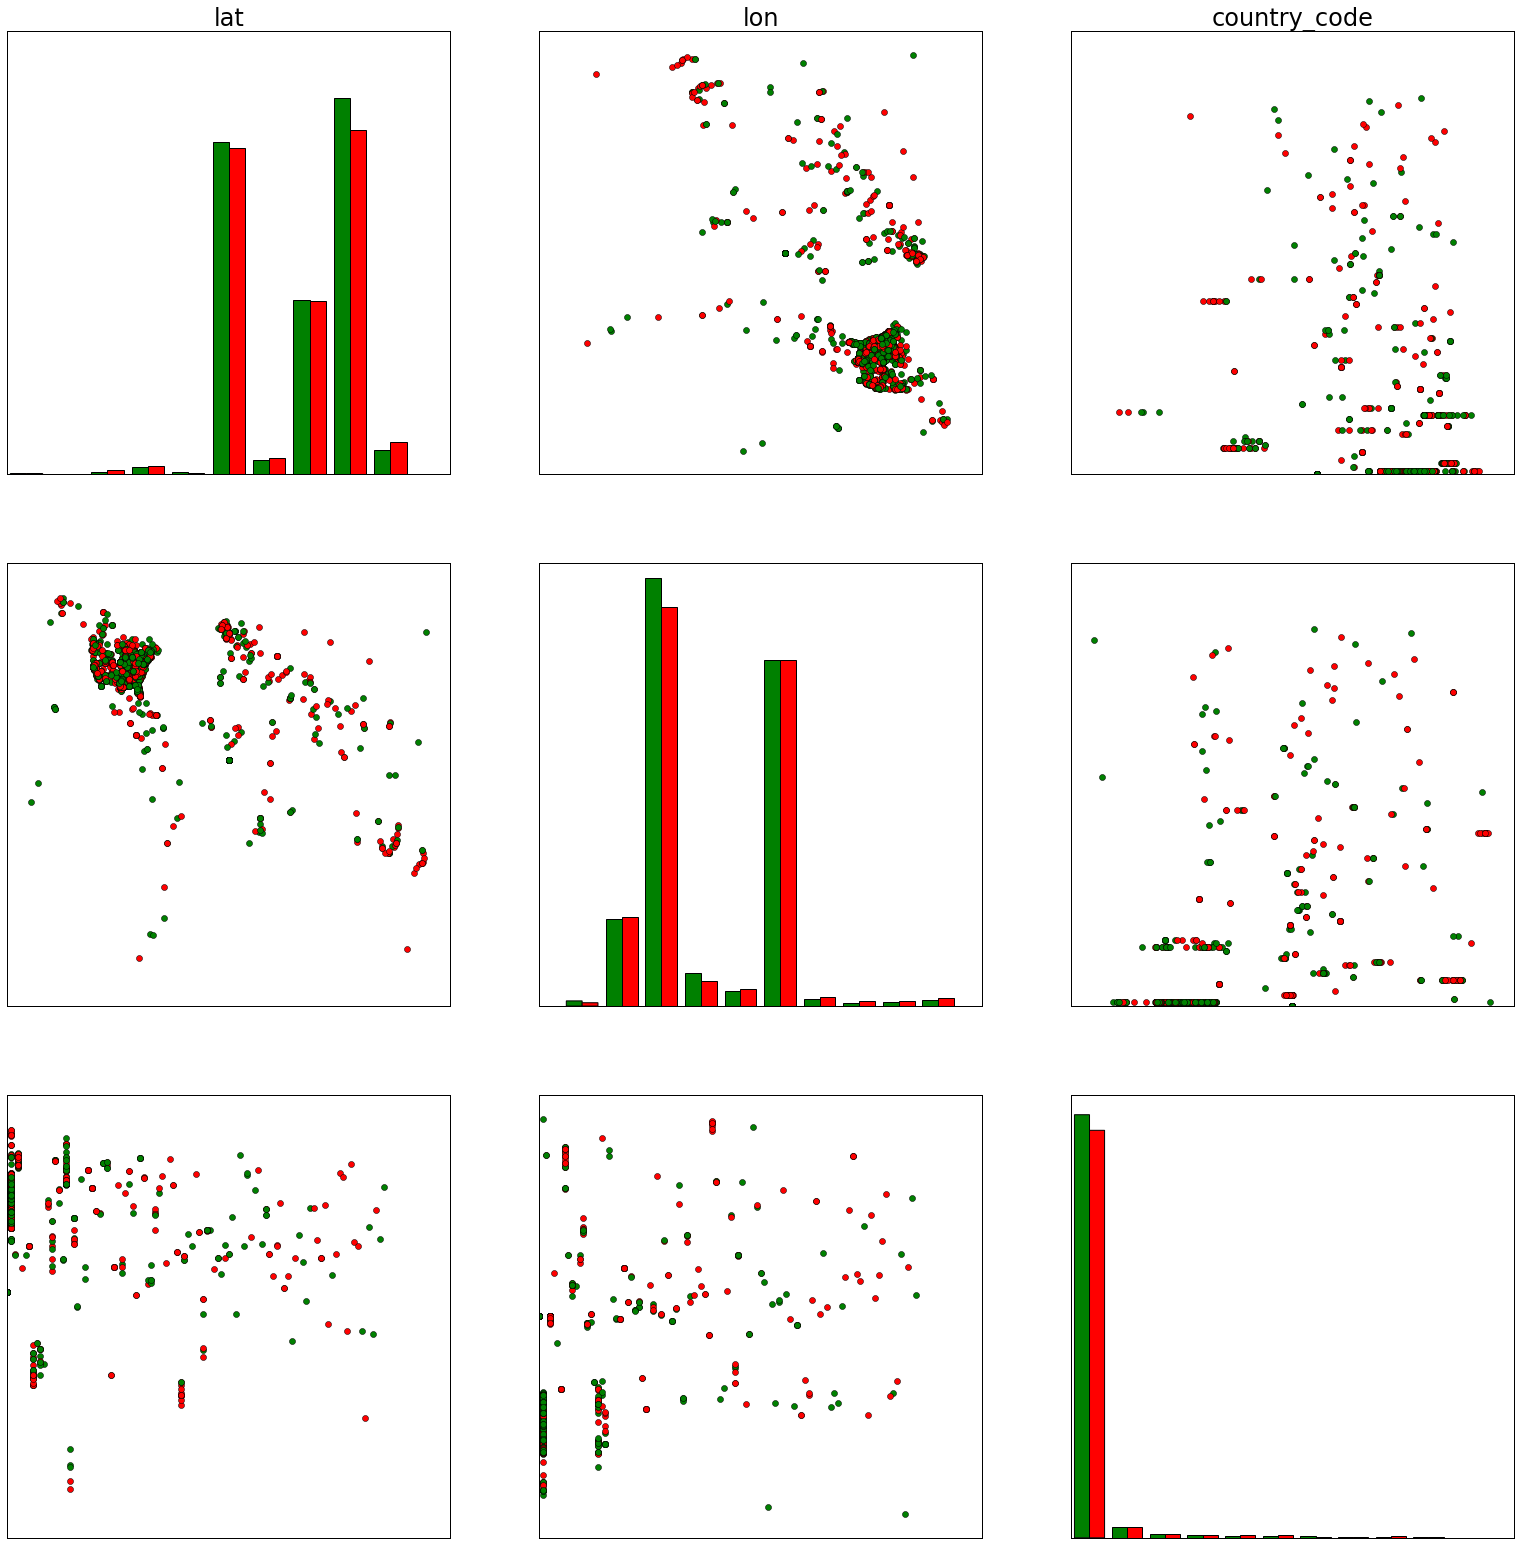

In [8]:
geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]

pl.rcParams.update({'font.size': 20})

geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

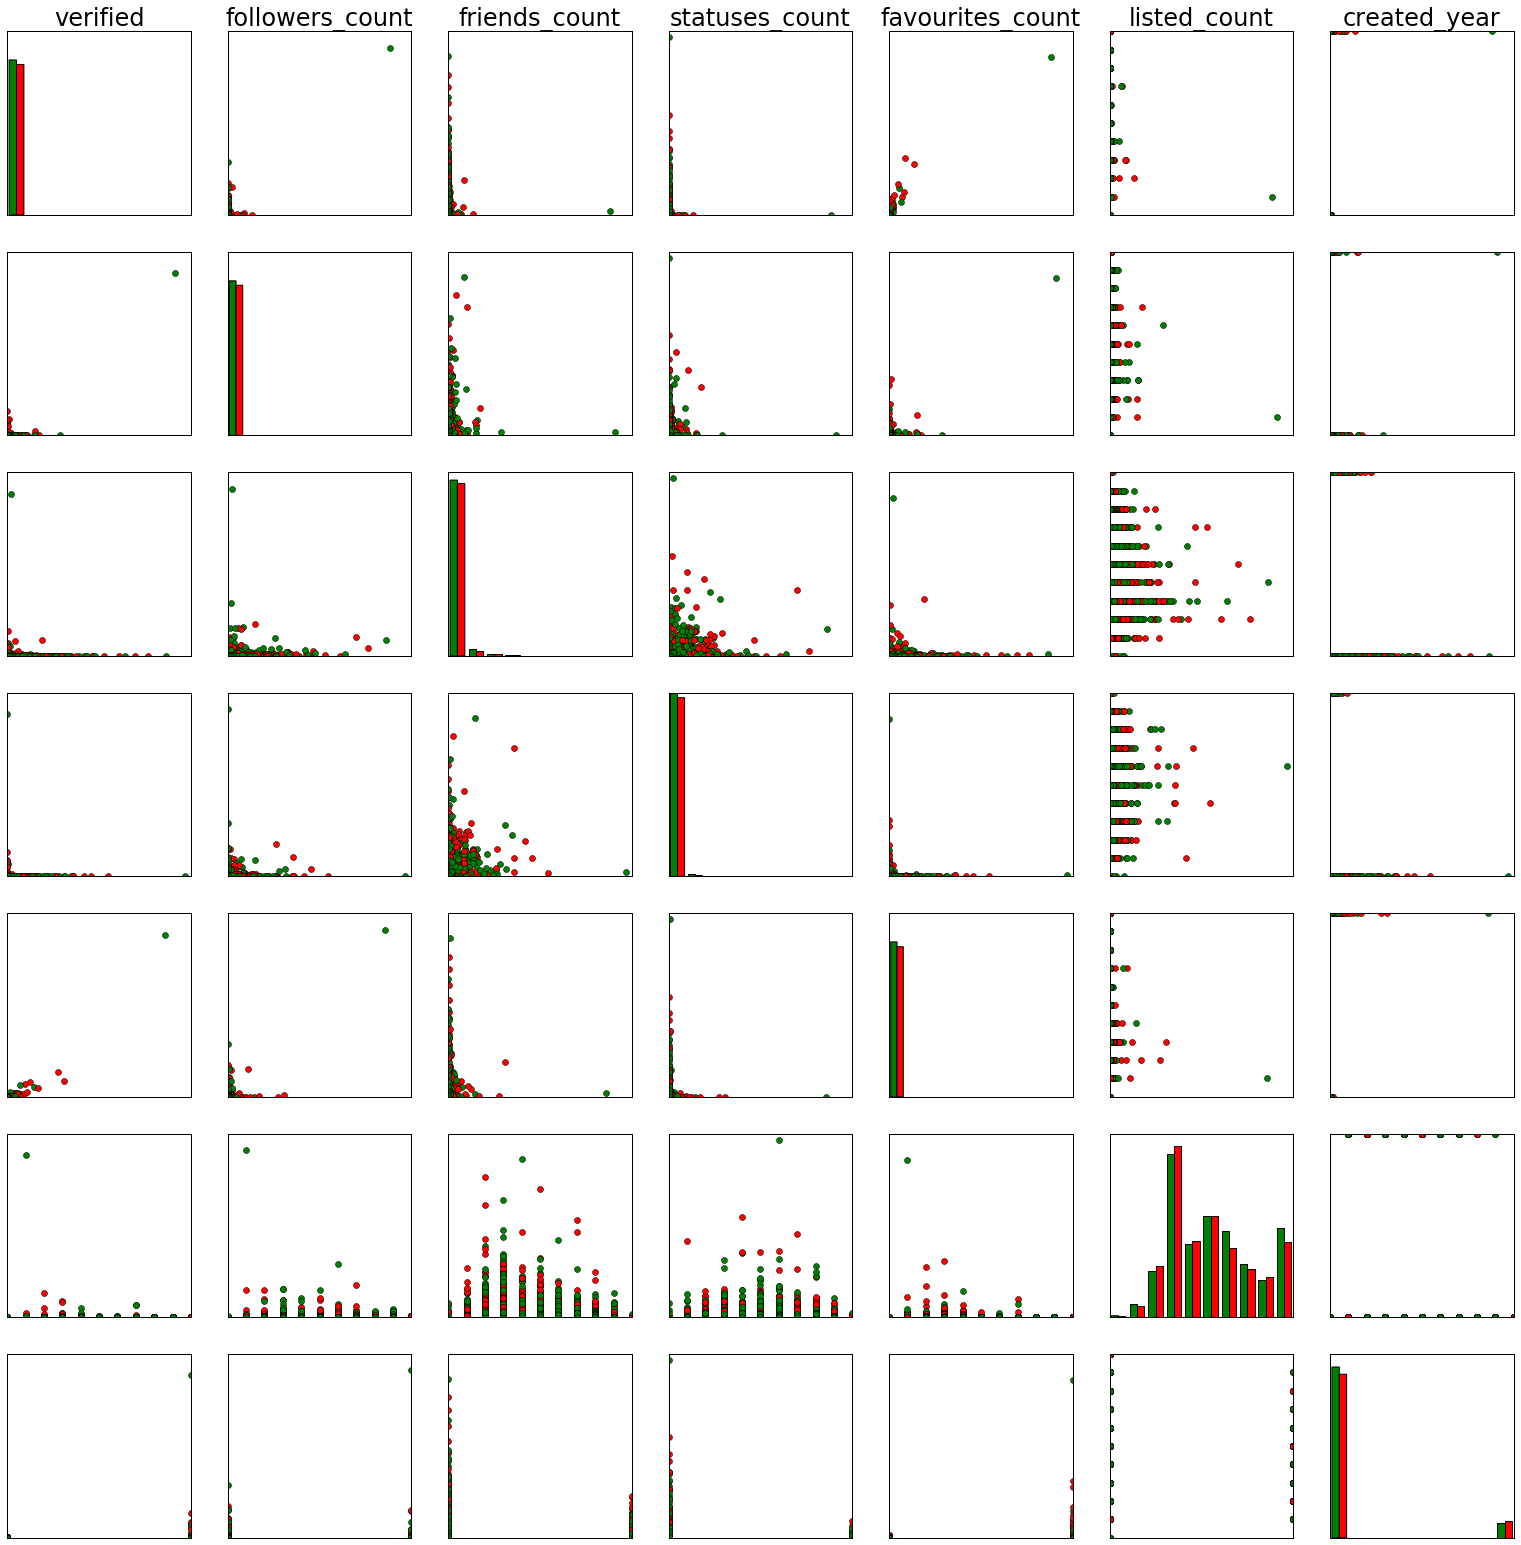

In [9]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_features = [f for f in social_features_new if f in features]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

In [10]:
def log_transform_features(data, features, transformed_features):
    # place your code here // Улучшить отображение графиков
    # transform selected features with log function
    transformed_features_ind = [i for i, f in enumerate(features) if f in transformed_features]
    for ind in transformed_features_ind:
        data[:, ind] = np.log(1 + data[:, ind])
    return data

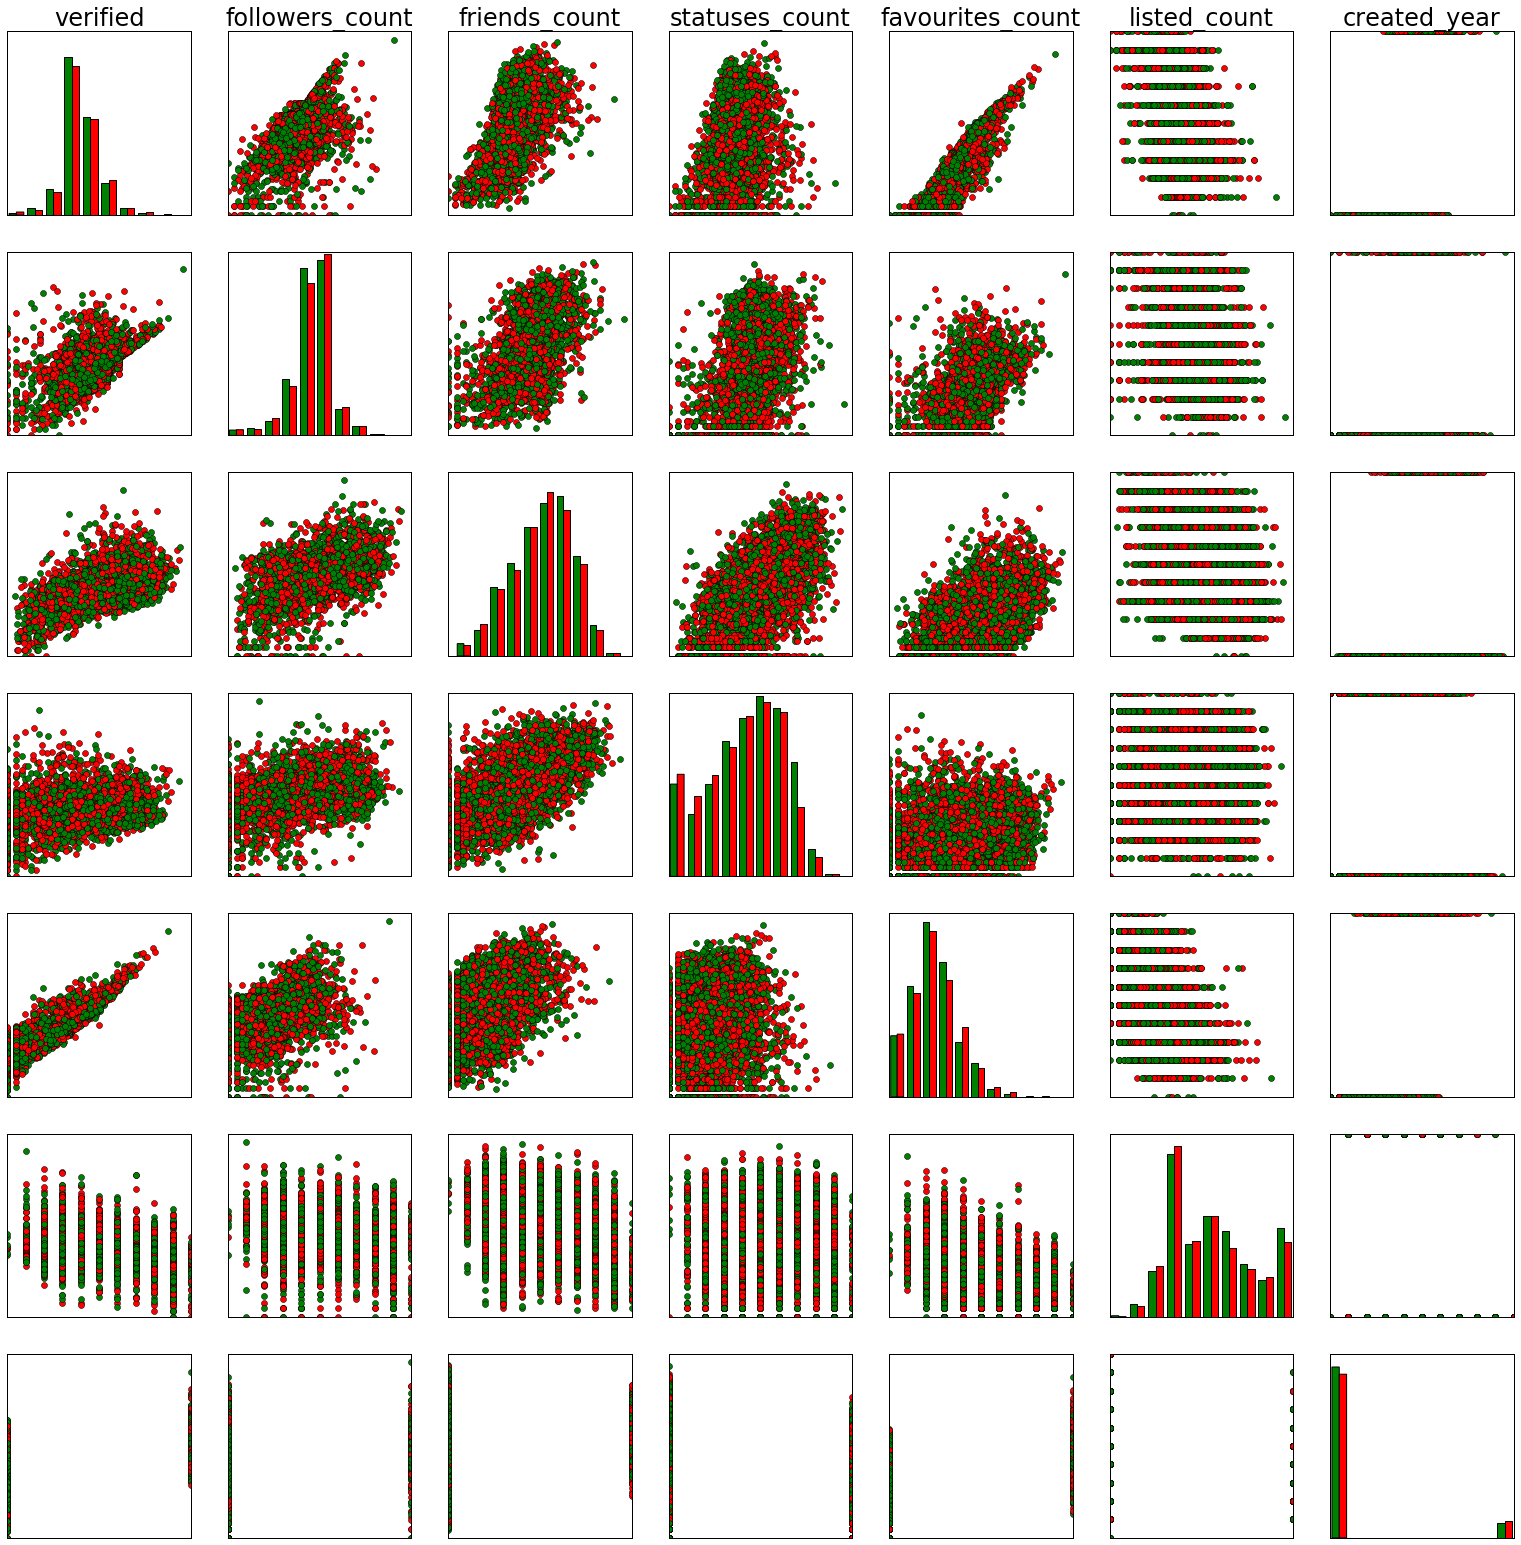

In [11]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

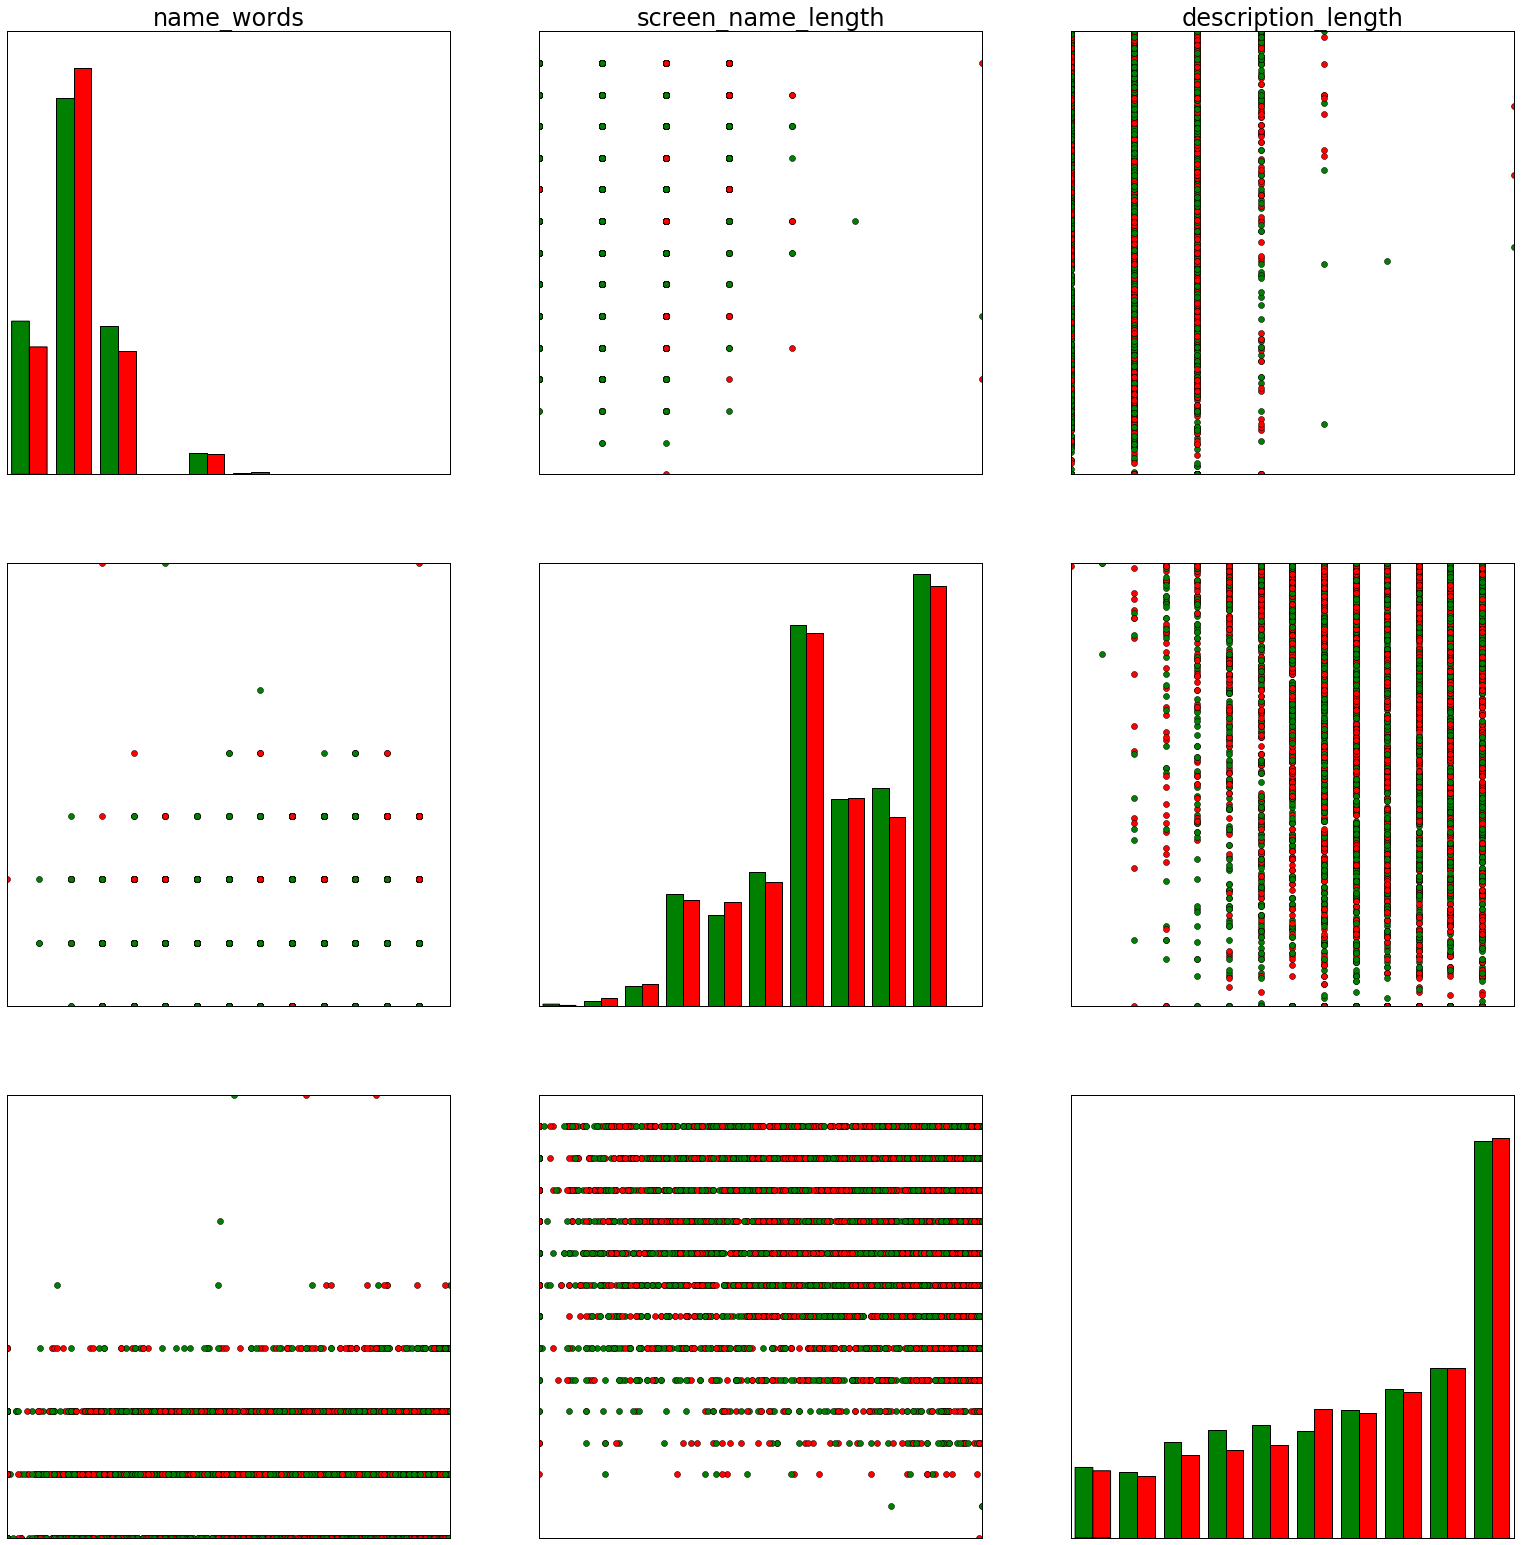

In [12]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
other_features = [f for f in other_features_new if f in features]
other_feature_ind = [i for i, f in enumerate(features) if f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

In [13]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].values
y = df_users["cat"].values

# x_1 = x[:, selected_features_ind]
# Replace nan with 0-s Нормализация признаков
# Is there a smarter way?
x_1[np.isnan(x_1)] = 0
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

In [14]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out_Zhiganov_Roman.csv", sep="\t")